## AMM Optimization, 2nd model (trading fees)

In the first experiment, we did not model the trading fees when executing a trade over a specific AMM. 

This approach is not realistic, as the trading fees are a significant part of the total cost of a trade for large trades. Moreover, in practice the pools on DEX are created by liquidity providers, who are incentivized to charge fees to the traders (in return for providing liquidity). In this experiment, we model the trading fees as a percentage of the trade size.

### 1. Problem formulation

Our approach for the modelization of the trading fees is derived from [Uniswap Whitepaper](https://hackmd.io/C-DvwDSfSxuh-Gd4WKE_ig).

let f be the trading fee for an AMM

I want to buy $ \Delta x $ ETH for $ \Delta y $ USDT 
If I send $ \Delta y $ USDT to the AMM, $f$% of it will be charged as a fee, so I will make the trade with $ \Delta y (1-f) $
The AMM will send me $ \Delta x $ ETH, and will receive $ \Delta y (1-f) $ USDT. Then, the invariant will be updated.

Therefore we have:

\begin{align} 
    (x_{eth} - \Delta x_{eth}) (y_{usd} + \Delta y_{usd}(1-f)) = x_{eth}y_{usd} \\
    \Delta y_{usd} = \frac{y_{usd} \Delta x_{eth}}{(1-f)(x_{eth} - \Delta x_{eth})} \\    
\end{align}



After that, the fee is added the the USDT pool, which makes the invariant change.

\begin{align} 
    x_{eth_{new}} = x_{eth} - \Delta x_{eth} \\
    y_{usd_{new}} = y_{usd} + \Delta y_{usd} \\
    invariant_{{new}} = x_{eth_{new}}y_{usd_{new}} 
\end{align}

So the quantity is bigger and the liquidity provider will receive some money afterwards


### 2. Implementation

In [1]:
using Gurobi, JuMP, CSV, Tables, Ipopt, Plots

In [2]:
# load data
#liquidity = CSV.read("../../data/ex_2_liquidity.csv", Tables.matrix)
#fees = CSV.read("../../data/ex_2_fees.csv", Tables.matrix)
#product = CSV.read("../../data/ex_2_k.csv", Tables.matrix); 

#liquidity = liquidity[1:size(fees, 1),:];

#println("Prices from the liquidity model", liquidity[:,2] ./ liquidity[:,1])

In [3]:
# With an order amount of token x
function optimize_price_paid_with_fees(liquidity, fees, order_amount)

    amount_token_x_per_pool = liquidity[:, 1] 
    amount_token_y_per_pool = liquidity[:, 2]

    # Create a new model
    model = Model(Ipopt.Optimizer)

    # Create variables
    @variable(model, x[1:size(liquidity,1)] >= 0)

    # Set objective
    @NLobjective(model, Min, sum((amount_token_y_per_pool[i] * x[i])/((1-fees[i])*(amount_token_x_per_pool[i]- x[i])) for i in 1:size(liquidity,1)))

    # Add constraint
    @constraint(model, sum(x) == order_amount)
    @constraint(model, x .<= amount_token_x_per_pool)

    # Optimize model
    optimize!(model)

    # Return the optimal solution
    return value.(x)
end

optimize_price_paid_with_fees (generic function with 1 method)

In [4]:
# With an order amount of token x
function optimize_market_impact_with_fees(liquidity, fees, order_amount)

    amount_token_x_per_pool = liquidity[:, 1] 
    amount_token_y_per_pool = liquidity[:, 2]

    # Create a new model
    model = Model(Ipopt.Optimizer)

    # Create variables
    @variable(model, x[1:size(liquidity,1)] >= 0)

    # Set objective
    @NLobjective(model, Min, sum(
        amount_token_y_per_pool[i] * (
            (x[i]*(2*amount_token_x_per_pool[i] - x[i]) )/(x[i]*(amount_token_x_per_pool[i]- x[i])^2) +
            fees[i]*x[i]/((1-fees[i])*(amount_token_x_per_pool[i]- x[i])^2))
        for i in 1:size(liquidity,1)))

    # Add constraint
    @constraint(model, sum(x) == order_amount)
    @constraint(model, x .<= amount_token_x_per_pool)

    # Optimize model
    optimize!(model)

    # Return the optimal solution
    return value.(x)
end

optimize_market_impact_with_fees (generic function with 1 method)

In [14]:
function plot_with_fees(liquidity, split_trades)
    liquidity_invariants = zeros(size(liquidity,1))
    for i in 1:size(liquidity,1)
        liquidity_invariants[i] = liquidity[i,1] * liquidity[i,2]
    end

    delta_token_x = zeros(size(liquidity,1))
    for i in 1:size(liquidity,1)
        delta_token_x[i] = liquidity[i,1] - split_trades[i]
    end

    delta_token_y = zeros(size(liquidity,1))
    for i in 1:size(liquidity,1)
        delta_token_y[i] = liquidity[i,2] + (liquidity[i,2]*split_trades[i]/(liquidity[i,1] - split_trades[i]))
    end

    # reset the plot
    plot()

    # give me size(liquidity,1) different colors 
    colors = distinguishable_colors(size(liquidity,1))

    # Plot the liquidity pools curves for the pools
    for i in 1:size(liquidity,1)
        plot!(1000:100:liquidity[i,1] + 3000, x -> liquidity_invariants[i]/x, label="Pool $i, fee $(fees[i])", color=colors[i])
        #Add the pool points same coloration as the curve
        scatter!([liquidity[i,1]], [liquidity[i,2]], label="", color=colors[i], markersize=3)
        #Add the pool points same coloration as the curve
        scatter!([delta_token_x[i]], [delta_token_y[i]], label="", color=colors[i], markersize=3)
        # Add arrows to show the trade
        plot!([liquidity[i,1], delta_token_x[i]], [liquidity[i,2], delta_token_y[i]], label="", color=colors[i], arrow=true)
    end

    #plot!([liquidity[:,1]; delta_token_x], [liquidity[:,2]; delta_token_y], label="")

    # show the plot and legend top right
    plot!(xlabel="Token X", ylabel="Token Y", legend=:topright, title="Liquidity Pools Curves", size=(800, 600), grid=false)
end

plot_with_fees (generic function with 1 method)

In [5]:
ETH_USDT = 1210;
# arrange for ETH
ETH = rand(3000:3500, 12)
ETH = sort(ETH, rev=false)
USD = ETH .* ETH_USDT
liquidity = [ETH USD];
fees = rand([0.3, 0.1, 0.01], 12)


println("ETH amount", liquidity[:, 1])
println("USDT amount", liquidity[:, 2])
println("Fees", fees)
order_amount = 1000
println("Order amount", order_amount)

split_trades = optimize_price_paid_with_fees(liquidity, fees, order_amount)

ETH amount[3012, 3088, 3133, 3234, 3259, 3287, 3342, 3384, 3410, 3441, 3463, 3499]
USDT amount[3644520, 3736480, 3790930, 3913140, 3943390, 3977270, 4043820, 4094640, 4126100, 4163610, 4190230, 4233790]
Fees[0.01, 0.01, 0.01, 0.1, 0.3, 0.1, 0.1, 0.01, 0.01, 0.1, 0.3, 0.1]
Order amount1000

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:     

12-element Vector{Float64}:
 162.9190146192211
 167.02985296950033
 169.46390199269166
  25.617159705749536
  -9.880530192924482e-9
  26.03698328778507
  26.472649269141698
 183.0404865442716
 184.44682597989342
  27.256848035583054
  -9.880530194394164e-9
  27.716277615923833

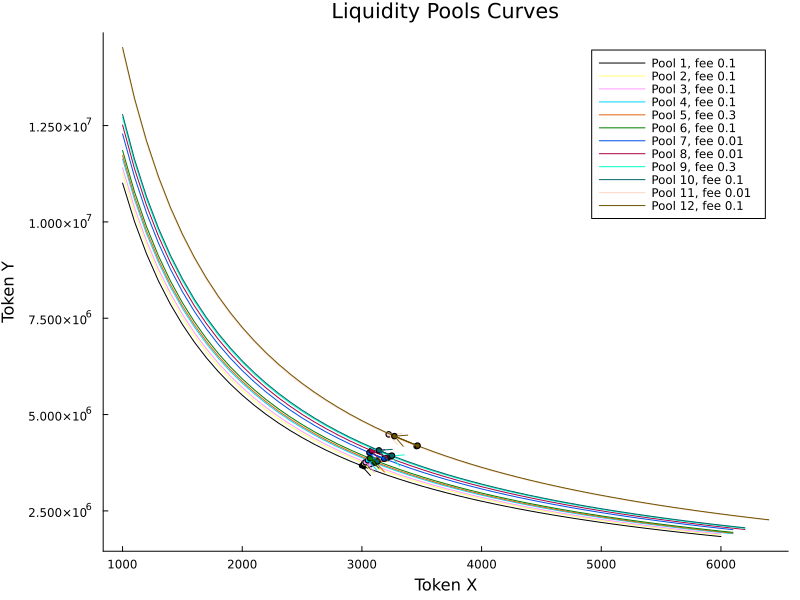

In [19]:
plot_with_fees(liquidity, split_trades)

In [8]:
price = sum((split_trades[i]/order_amount)*liquidity[i, 2] / ((1-fees[i])*(liquidity[i, 1] - split_trades[i])) for i in 1:size(liquidity,1)) 
price_exec_baseline_pool = [liquidity[i, 2] / ((1-fees[i])*(liquidity[i, 1] - order_amount)) for i in 1:size(liquidity,1)]
avg_split = [order_amount / size(liquidity,1) for i in 1:size(liquidity,1)]
price_avg_amm = sum((avg_split[i]/order_amount)*liquidity[i, 2] / ((1-fees[i])*(liquidity[i, 1] - avg_split[i])) for i in 1:size(liquidity,1))
println("Price with split trades: ", price)
println("Price without split trades: ", price_exec_baseline_pool)
println("Price with even split on all Amms: ", price_avg_amm)

Price with split trades: 1300.506712101269
Price without split trades: [1829.6885354539431, 1807.5776926351639, 1795.2284211074646, 1946.2548492987166, 2493.764624043509, 1932.30821551766, 1918.502704241389, 1734.8993288590605, 1729.3683725218993, 1895.2205380308617, 2430.3868685111074, 1882.4374194122095]
Price with even split on all Amms: 1392.7572270395535


##### Invariants analysis

In [9]:
del_y = [liquidity[i, 2]*split_trades[i]/ ((1-fees[i])*(liquidity[i, 1] - split_trades[i])) for i in 1:size(liquidity,1)]
println("Invariants before", [liquidity[i, 2] * liquidity[i, 1] for i in 1:size(liquidity,1)])
println("Invariants after", [(liquidity[i, 2] + del_y[i]) * (liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)])



Invariants before[10977294240, 11538250240, 11876983690, 12655094760, 12851508010, 13073286490, 13514446440, 13856261760, 14070001000, 14326982010, 14510766490, 14814031210]
Invariants after[1.0983291831991516e10, 1.1544554317828522e10, 1.188347283939375e10, 1.2666232930258995e10, 1.2851508009983303e10, 1.3084792724724558e10, 1.3526340954285282e10, 1.3863832314523472e10, 1.4077688333825008e10, 1.433959166389438e10, 1.4510766489982258e10, 1.4827069532111946e10]


#### Market impact: TODO (not done) copied past from the first experiment (not adapted)

In [10]:
del_y = [liquidity[i, 2]*split_trades[i]/(liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)]
price_post_trade_per_pool = [(liquidity[i, 2] + del_y[i])/ (liquidity[i, 1] - split_trades[i]) for i in 1:size(liquidity,1)]

# Comparison with an average split
avg_split = [order_amount / size(liquidity,1) for i in 1:size(liquidity,1)]
del_y_avg = [liquidity[i, 2]*avg_split[i]/(liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1)]
price_post_trade_per_pool_avg = [(liquidity[i, 2] + del_y_avg[i])/ (liquidity[i, 1] - avg_split[i]) for i in 1:size(liquidity,1)]

# Comparison with doing the trade on a single pool (each element in the array is "if we did the trade on this pool")
del_y_pool = [liquidity[i, 2]*order_amount/(liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]
price_post_trade_per_pool_pool = [(liquidity[i, 2] + del_y_pool[i])/ (liquidity[i, 1] - order_amount) for i in 1:size(liquidity,1)]

println("Simulated price after trade per pool: ", price_post_trade_per_pool)
println("Simulated price after trade per pool if we had done an average split: ", price_post_trade_per_pool_avg)
println("Simulated price after trade per pool if we had done the trade on a single pool (displayed for all the pools): ", price_post_trade_per_pool_pool)

Simulated price after trade per pool: [1352.3394484768621, 1352.339448476856, 1352.3394484768523, 1229.399498616613, 1209.999999992663, 1229.3994986165892, 1229.3994986165646, 1352.3394484768346, 1352.339448476833, 1229.3994986165221, 1209.9999999930953, 1229.3994986164994]
Simulated price after trade per pool if we had done an average split: [1279.8392264580434, 1278.0485608044366, 1277.0309247680414, 1274.8540998920264, 1274.3369335343198, 1273.7674110993823, 1272.677555391339, 1271.8700611988193, 1271.3805265842307, 1270.8068791655917, 1270.406235562587, 1269.761901907057]
Simulated price after trade per pool if we had done the trade on a single pool (displayed for all the pools): [2711.6857107849924, 2646.543063078933, 2610.5045180011207, 2535.7069670406645, 2518.3821322843983, 2499.496018349757, 2463.9079563694495, 2437.9993018332507, 2422.479123982025, 2404.4688587577944, 2392.0019520738024, 2372.1423279195633]


In [11]:
# Second Experiment, minimizing the market impact

In [12]:
ETH_USDT = 1210;
# arrange for ETH
ETH = rand(3000:3500, 12)
ETH = sort(ETH, rev=false)
USD = ETH .* ETH_USDT
liquidity = [ETH USD];
fees = rand([0.3, 0.1, 0.01], 12)


println("ETH amount", liquidity[:, 1])
println("USDT amount", liquidity[:, 2])
println("Fees", fees)
order_amount = 1000
println("Order amount", order_amount)

split_trades = optimize_market_impact_with_fees(liquidity, fees, order_amount)

ETH amount[3016, 3051, 3070, 3101, 3113, 3130, 3186, 3216, 3241, 3251, 3457, 3465]
USDT amount[3649360, 3691710, 3714700, 3752210, 3766730, 3787300, 3855060, 3891360, 3921610, 3933710, 4182970, 4192650]
Fees[0.1, 0.1, 0.1, 0.1, 0.3, 0.1, 0.01, 0.01, 0.3, 0.1, 0.01, 0.1]
Order amount1000
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:       12
                     variables with only lower bounds:       12
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:        0


12-element Vector{Float64}:
  19.54099160333876
  32.61735393749608
  39.753047586104366
  51.45083205504282
   3.0232765650891455e-8
  62.45532017460397
 123.17365646632243
 135.1257064648384
   2.497684038812034e-7
 108.99447269893449
 233.24354519321093
 193.64507354010664

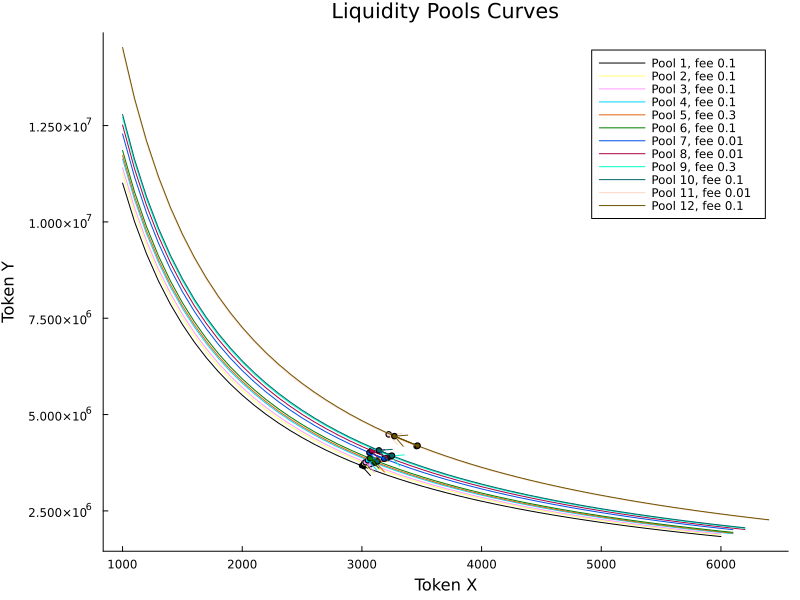

In [20]:
plot_with_fees(liquidity, split_trades)